In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime, timedelta
from ipywidgets import interact
from tqdm.notebook import tqdm

from eventbee import chronogram

# Load ready-made event dataframe

In [3]:
# Load full dataframe of events
full_df = pd.read_parquet('~/plotbee/notebooks/one_week_analysis_800__tracks__with_labelbee_videoid.parquet')
full_df.shape

(1958893, 27)

In [4]:
# Select tag ids that have 5 events or more
id_counts = full_df['track_tagid'].dropna().astype(int).value_counts().rename('counts')
tids = id_counts[id_counts>=5].index
tids = np.sort(tids).astype(int)

# Custom tids
#tids = np.array([1609,1621],dtype=int)

tids

array([ 197,  508,  515,  516,  517,  638,  661,  677,  930,  986, 1109,
       1230, 1237, 1361, 1404, 1407, 1415, 1607, 1609, 1621, 1651, 1652,
       1698, 1722, 1780, 1786, 1797, 1900, 1979, 2258, 2487])

In [5]:
# Restrict data to selected tag ids
vdf = full_df[full_df.track_tagid.isin(tids)].copy()
vdf['track_tagid'] = vdf['track_tagid'].astype(int) # Convert to int after removing the NaNs
vdf.shape

(5024, 27)

## Explore event dataframe content

In [7]:
#full_df.columns
list(full_df.dtypes.astype(str).items())

[('track_id', 'int64'),
 ('track_pollen_score', 'float64'),
 ('track_shape', 'object'),
 ('track_event', 'object'),
 ('track_tagid', 'float64'),
 ('track_hastag', 'bool'),
 ('track_startframe', 'int64'),
 ('track_startx', 'int64'),
 ('track_starty', 'int64'),
 ('track_starta', 'float64'),
 ('track_endframe', 'int64'),
 ('track_endx', 'int64'),
 ('track_endy', 'int64'),
 ('track_enda', 'float64'),
 ('track_length', 'int64'),
 ('datetime', 'datetime64[us]'),
 ('track_starttime', 'datetime64[us]'),
 ('track_endtime', 'datetime64[us]'),
 ('pollen', 'bool'),
 ('entering', 'bool'),
 ('leaving', 'bool'),
 ('entering_leaving', 'bool'),
 ('walking', 'bool'),
 ('video_name', 'object'),
 ('labelbee_videoid', 'int64'),
 ('video_filename', 'object'),
 ('video_seq', 'int64')]

In [8]:
full_df.track_shape.unique()

array(['inside', 'ramp-inside', 'outside_inside', 'ramp_ramp', 'noise',
       'inside_ramp', 'ramp_outside', 'outside_ramp', 'outside',
       'inside_out', 'outside_outside', 'inside_inside', None],
      dtype=object)

In [9]:
with pd.option_context('display.max_colwidth', 200):
  display( full_df[['labelbee_videoid','video_filename']].drop_duplicates().reset_index(drop=True) )

,labelbee_videoid,video_filename
0,10939,/mnt/storage/work/jchan/bees/tag_dataset/videos/C02_170621080000.mp4
1,15072,/mnt/storage/work/jchan/bees/tag_dataset/videos/C02_170621090000.mp4
2,14393,/mnt/storage/work/jchan/bees/tag_dataset/videos/C02_170621100000.mp4
3,14803,/mnt/storage/work/jchan/bees/tag_dataset/videos/C02_170621110000.mp4
4,13079,/mnt/storage/work/jchan/bees/tag_dataset/videos/C02_170621120000.mp4
...,...,...
75,15661,/mnt/storage/work/jchan/bees/tag_dataset/videos/C02_170628130000.mp4
76,15160,/mnt/storage/work/jchan/bees/tag_dataset/videos/C02_170628140000.mp4
77,14442,/mnt/storage/work/jchan/bees/tag_dataset/videos/C02_170628150000.mp4
78,11037,/mnt/storage/work/jchan/bees/tag_dataset/videos/C02_170628160000.mp4


# Display event chronogram

## Simple inline plot

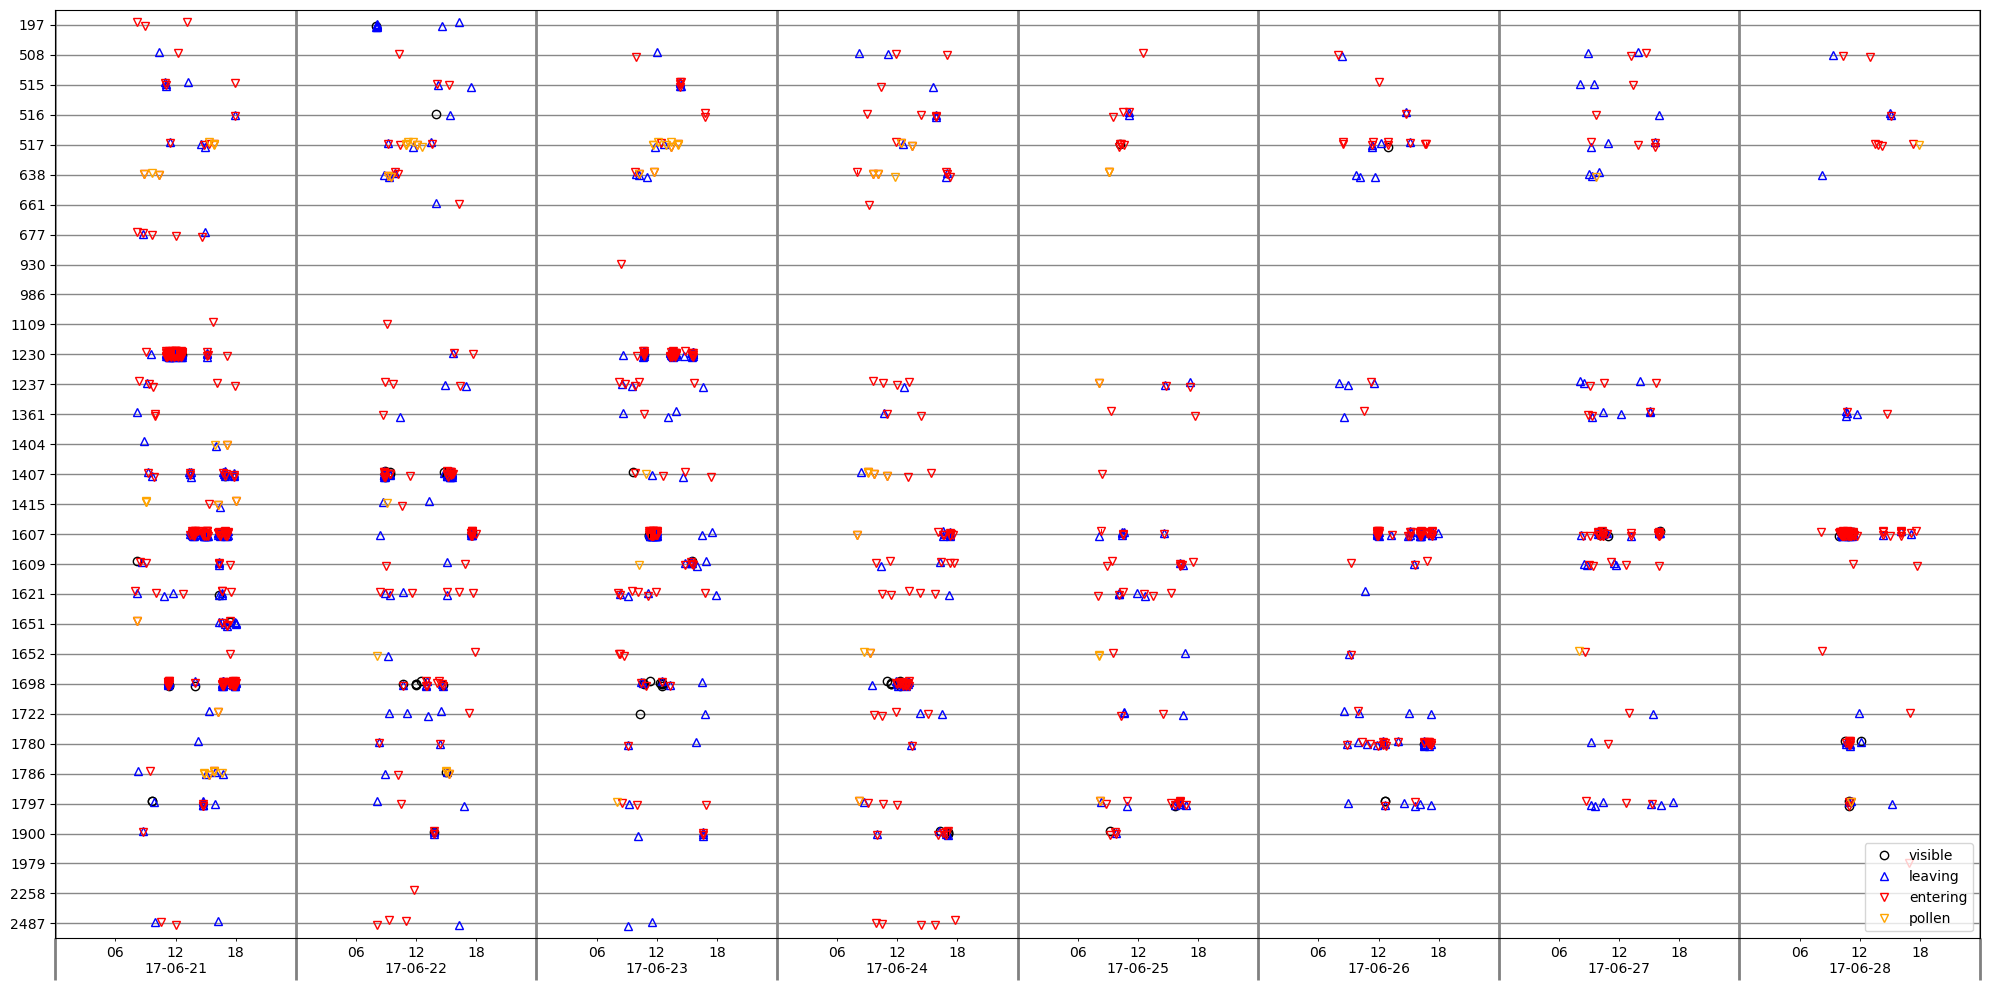

In [10]:
%matplotlib inline

from eventbee.chronogram import plot_activities_df, format_multiday

fig,axes = plt.subplots(1,1,figsize=(20,10))
plt.sca(axes)
plot_activities_df(vdf, plot_interval=True, tagids=None, leaving_symbol = '^', entering_symbol = 'v');
format_multiday()
plt.xlim(pd.to_datetime('2017-06-21 00:00'),pd.to_datetime('2017-06-29 00:00'))
plt.tight_layout();

plt.savefig("tagged_bees_activities.png")

## Widget based event plot (with click callback)

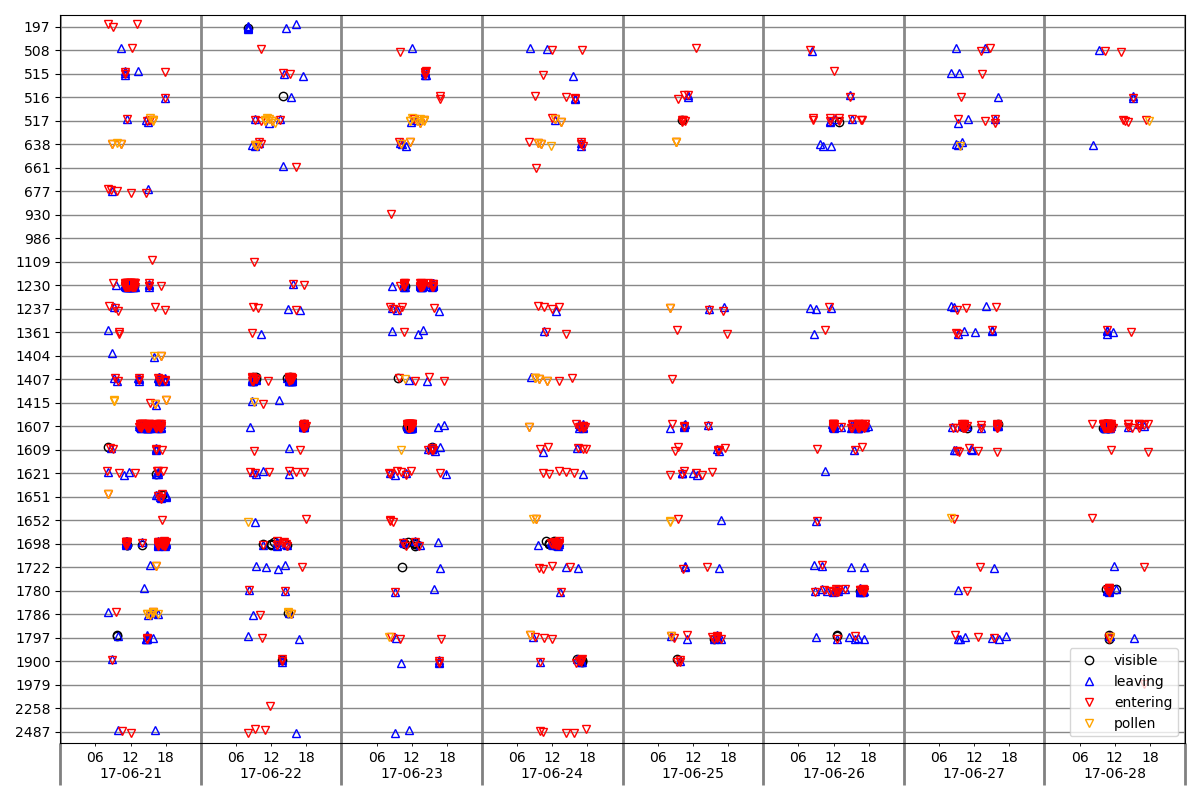

No such comm: f904b57acf8d49af953c48c177ff49fa
No such comm: f904b57acf8d49af953c48c177ff49fa
No such comm: f904b57acf8d49af953c48c177ff49fa
No such comm: f904b57acf8d49af953c48c177ff49fa
No such comm: f904b57acf8d49af953c48c177ff49fa
No such comm: f904b57acf8d49af953c48c177ff49fa
No such comm: f904b57acf8d49af953c48c177ff49fa
No such comm: f904b57acf8d49af953c48c177ff49fa
No such comm: f904b57acf8d49af953c48c177ff49fa
No such comm: f904b57acf8d49af953c48c177ff49fa
No such comm: f904b57acf8d49af953c48c177ff49fa
No such comm: f904b57acf8d49af953c48c177ff49fa
No such comm: f904b57acf8d49af953c48c177ff49fa
No such comm: f904b57acf8d49af953c48c177ff49fa
No such comm: f904b57acf8d49af953c48c177ff49fa
No such comm: f904b57acf8d49af953c48c177ff49fa
No such comm: f904b57acf8d49af953c48c177ff49fa
No such comm: f904b57acf8d49af953c48c177ff49fa
No such comm: f904b57acf8d49af953c48c177ff49fa
No such comm: f904b57acf8d49af953c48c177ff49fa
No such comm: f904b57acf8d49af953c48c177ff49fa
No such comm:

In [7]:
%matplotlib widget
# IMPORTANT: matplotlib widget requires `ipympl` installed in kernel environment with a compatible version to jupyterlab server environment.
# Check this if slider widgets do not appear, or an error about widgets is returned.
# See: https://matplotlib.org/ipympl/installing.html

# 1. Create an activity chronogram

from eventbee.chronogram import plot_activities_df, format_multiday

fig,axes = plt.subplots(1,1,figsize=(12,8))
plt.sca(axes)
plot_activities_df(vdf, plot_interval=True, tagids=None, leaving_symbol = '^', entering_symbol = 'v');
plt.xlim(pd.to_datetime('2017-06-21 00:00'),pd.to_datetime('2017-06-29 00:00'))
format_multiday()
plt.tight_layout();


# 2. Define and register click callback

from eventbee.chronogram import register_chronogram_event_click
from eventbee.labelbee_link import labelbee_url

def item_clicked_cb(clicked_item):
    # Example calbback to react to click on chronogram
    # Hardcoded axes needs to have axes.activity_data_ defined
    if (clicked_item is None): return
    axes.plot(clicked_item.track_starttime, axes.activity_data_['rmap'][clicked_item.track_tagid], 'k*')
    print(f'Event loc={clicked_item.name} track_tagid={clicked_item.track_tagid} track_starttime={clicked_item.track_starttime}')
    print(f'      video_filename={clicked_item.video_filename}')
    print(f'      labelbee_url: {labelbee_url(clicked_item)}')
    # Could do custom reaction to click

click_cb_id = register_chronogram_event_click(fig, vdf, axes, item_clicked_cb)

# Link to labelbee video

In [40]:
def labelbee_url(event):
    videoid = event['labelbee_videoid']
    frame = event['track_startframe']
    url = f"http://136.145.54.85/webapp/labelbee/gui#video_id={videoid}&frame={frame}" 
    return url
    
event_loc = 120607
event = full_df.loc[event_loc]
print(f"Event {event_loc}: ",labelbee_url(event))

Event 120607:  http://136.145.54.85/webapp/labelbee/gui#video_id=16141&frame=67706


In [26]:
full_df.labelbee_videoid.unique()

array([10939, 15072, 14393, 14803, 13079, 13490, 16141, 16035, 14469,
       13361, 15210, 11507, 12386, 15502, 15444, 13085, 12125, 11500,
       12950, 15683, 12454, 15398, 12718, 14693, 12558, 16249, 15022,
       13737, 16031, 10997, 12672, 12825, 15501, 15423, 11471, 14120,
       11431, 15410, 12508, 12409, 15388, 11183, 12139, 11269, 13893,
       11586, 12411, 12556, 12704, 11210, 14090, 14045, 15415, 15204,
       15932, 16152, 12979, 12342, 15421, 13592, 14424, 14174, 15633,
       11747, 11617, 12262, 15676, 15023, 15736, 12994, 11544, 13875,
       12265, 13272, 15080, 15661, 15160, 14442, 11037, 11282])

# Display of events in video in notebook

In [ ]:
# General imports
from decord import VideoReader
from decord import cpu, gpu
import ipywidgets
import PIL

## Manual display of one event

,677809
track_id,4462
track_pollen_score,0.014078
track_shape,outside_ramp
track_event,entering
track_tagid,661.0
track_hastag,True
track_startframe,9397
track_startx,2224
track_starty,836
track_starta,5.194429


Event 677809: http://136.145.54.85/webapp/labelbee/gui#video_id=12825&frame=9397


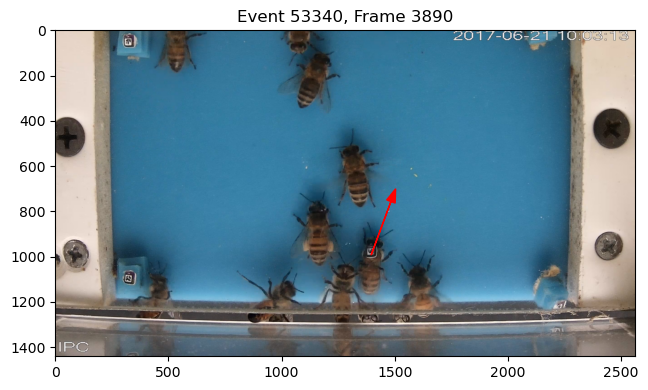

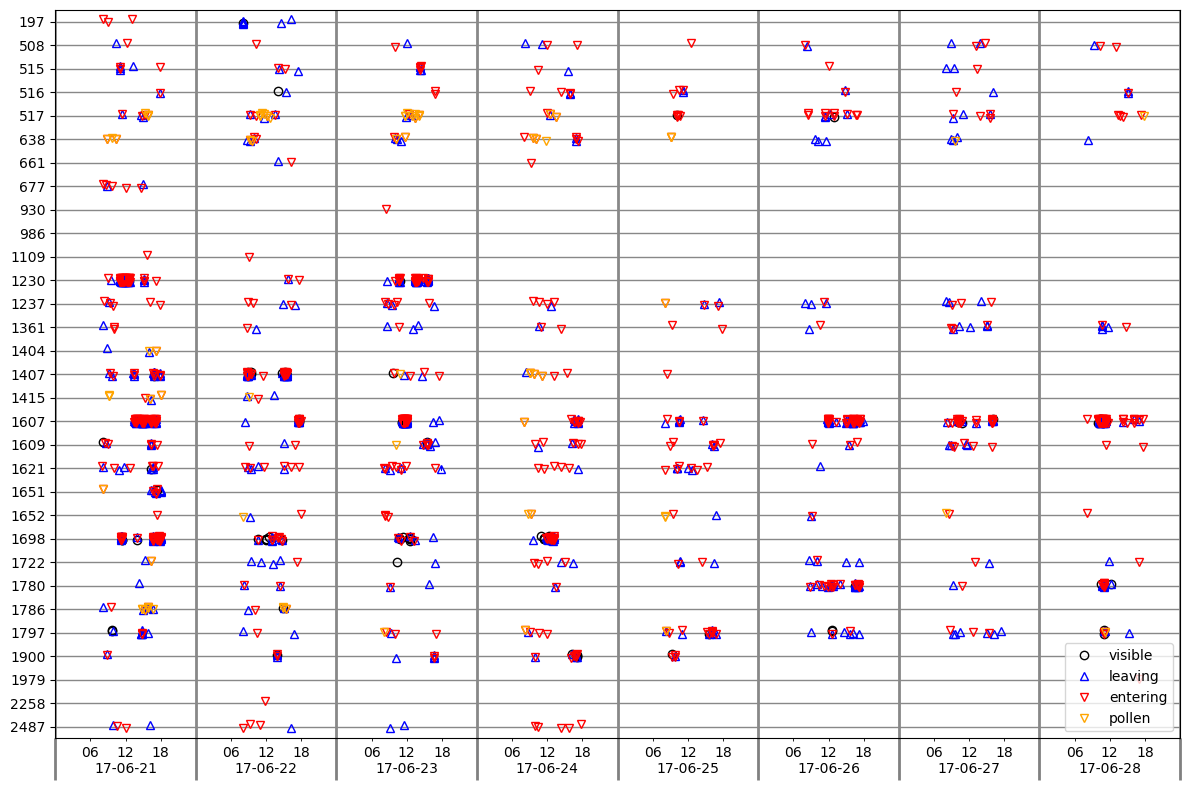

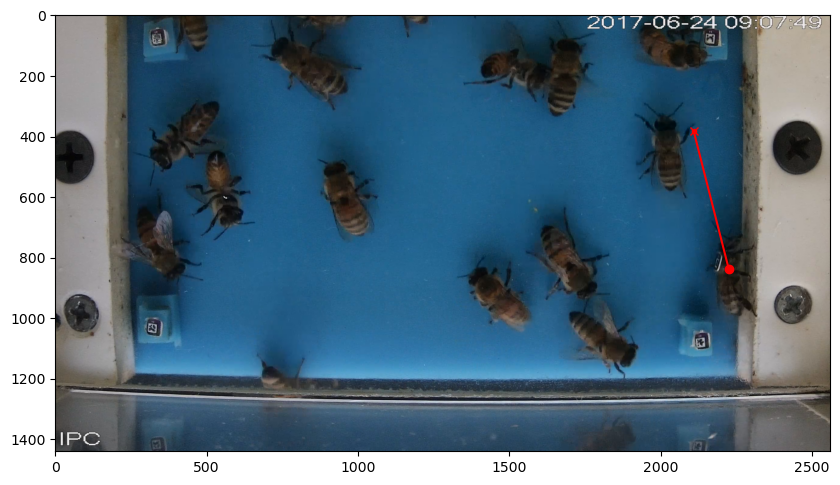

In [8]:
# Visualize one event manually
%matplotlib inline

from eventbee.video_plot import load_frame, plot_track
from eventbee.labelbee_link import labelbee_url

# Manual selection of event
loc = vdf.iloc[0].name
#event = full_df.iloc[10]

loc=677809 
event = full_df.loc[loc]

# Display of event data
with pd.option_context('display.max_colwidth', 200):
    display(pd.DataFrame(event))

# Link to view in Labelbee
print(f"Event {event.name}: {labelbee_url(event)}")

# Display of start_frame
fig = plt.figure(figsize=(10,6))
frame = event.track_startframe
plot_track(event, frame=frame, videoreader=None, ax=None);

## Manual display of one event with frame navigation

interactive(children=(IntSlider(value=195, continuous_update=False, description='frame', max=71999), IntSlider…

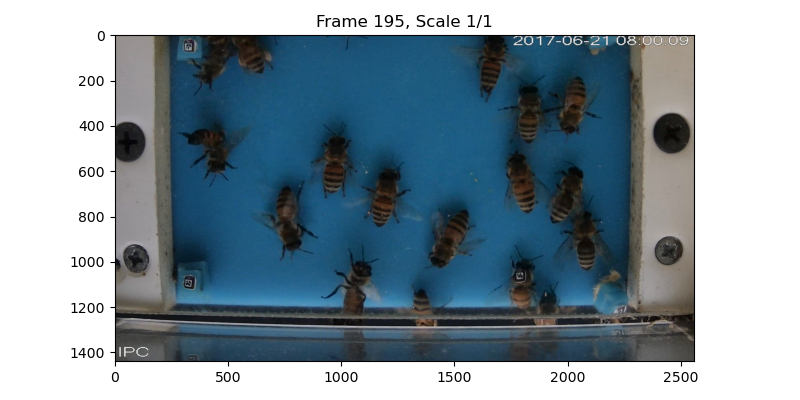

In [8]:
%matplotlib widget

from eventbee.video_plot import GUI_PlotVideo

# Pick up an event to display
event = vdf.iloc[0]

gui = GUI_PlotVideo(event['video_filename'], event['track_startframe']);

## Selection of events from vdf dataframe

In [6]:
%matplotlib widget

from eventbee.video_plot import GUI_BrowseEvents

gui = GUI_BrowseEvents(vdf)